 # ----------------------------Credit Risk Scoring -------------------------------------


### Step 1 Code: Load + Prepare the Dataset

#### Import Libraries 

In [144]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)
import joblib

In [145]:


# Define column names based on dataset documentation
columns = [
    'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_account', 'employment_since', 'installment_rate', 'personal_status_sex',
    'guarantors', 'residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'existing_credits', 'job', 'num_liable_people', 'telephone', 'foreign_worker', 'target'
]

# Load dataset
df = pd.read_csv(r"C:\Users\ashid\Downloads\statlog+german+credit+data\german.data", sep=' ', header=None, names=columns)

# Map target variable: 1 (good) → 0, 2 (bad) → 1 (to treat as binary labels 0/1)
df['target'] = df['target'].map({1: 0, 2: 1})

# Check dataset shape and preview
print(f"Dataset shape: {df.shape}")
df.head()

# Show target distribution
print("\nTarget distribution:")
print(df['target'].value_counts())


Dataset shape: (1000, 21)

Target distribution:
target
0    700
1    300
Name: count, dtype: int64


### Step 2: Exploratory Data Analysis (EDA)

#### 1. Check for missing values:

In [148]:
# Check for missing values in each column
print(df.isnull().sum())

checking_account           0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings_account            0
employment_since           0
installment_rate           0
personal_status_sex        0
guarantors                 0
residence_since            0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
num_liable_people          0
telephone                  0
foreign_worker             0
target                     0
dtype: int64


In [149]:
# Check data types of each column
print(df.dtypes)


checking_account           object
duration                    int64
credit_history             object
purpose                    object
credit_amount               int64
savings_account            object
employment_since           object
installment_rate            int64
personal_status_sex        object
guarantors                 object
residence_since             int64
property                   object
age                         int64
other_installment_plans    object
housing                    object
existing_credits            int64
job                        object
num_liable_people           int64
telephone                  object
foreign_worker             object
target                      int64
dtype: object


#### 2. Distribution of the target variable:

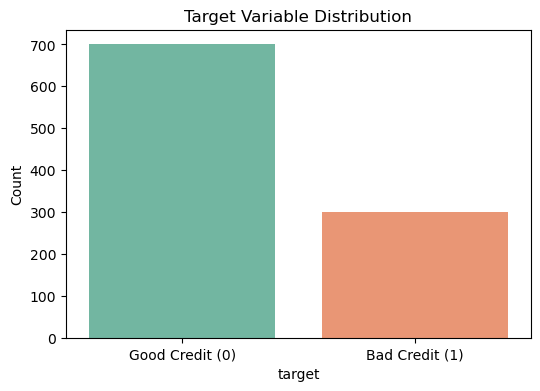

target
0    0.7
1    0.3
Name: proportion, dtype: float64


In [151]:

#Helps check class imbalance.
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, hue='target', palette='Set2', legend=False)
plt.title('Target Variable Distribution')
plt.xticks([0, 1], ['Good Credit (0)', 'Bad Credit (1)'])
plt.ylabel('Count')
plt.show()

print(df['target'].value_counts(normalize=True).round(2))


#### 3. Summary statistics for numerical features:¶

In [153]:

# Select numeric feature columns (exclude 'target')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('target')  # Exclude the target column

# Summary statistics for only numerical features
print("Summary statistics for numeric features (excluding target):")
print(df[numeric_cols].describe())




#numeric_cols = ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_liable_people']
#df[numeric_cols].describe().T  # Summary stats



Summary statistics for numeric features (excluding target):
          duration  credit_amount  installment_rate  residence_since  \
count  1000.000000    1000.000000       1000.000000      1000.000000   
mean     20.903000    3271.258000          2.973000         2.845000   
std      12.058814    2822.736876          1.118715         1.103718   
min       4.000000     250.000000          1.000000         1.000000   
25%      12.000000    1365.500000          2.000000         2.000000   
50%      18.000000    2319.500000          3.000000         3.000000   
75%      24.000000    3972.250000          4.000000         4.000000   
max      72.000000   18424.000000          4.000000         4.000000   

               age  existing_credits  num_liable_people  
count  1000.000000       1000.000000        1000.000000  
mean     35.546000          1.407000           1.155000  
std      11.375469          0.577654           0.362086  
min      19.000000          1.000000           1.000000  
2

Numeric feature columns: ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_liable_people']


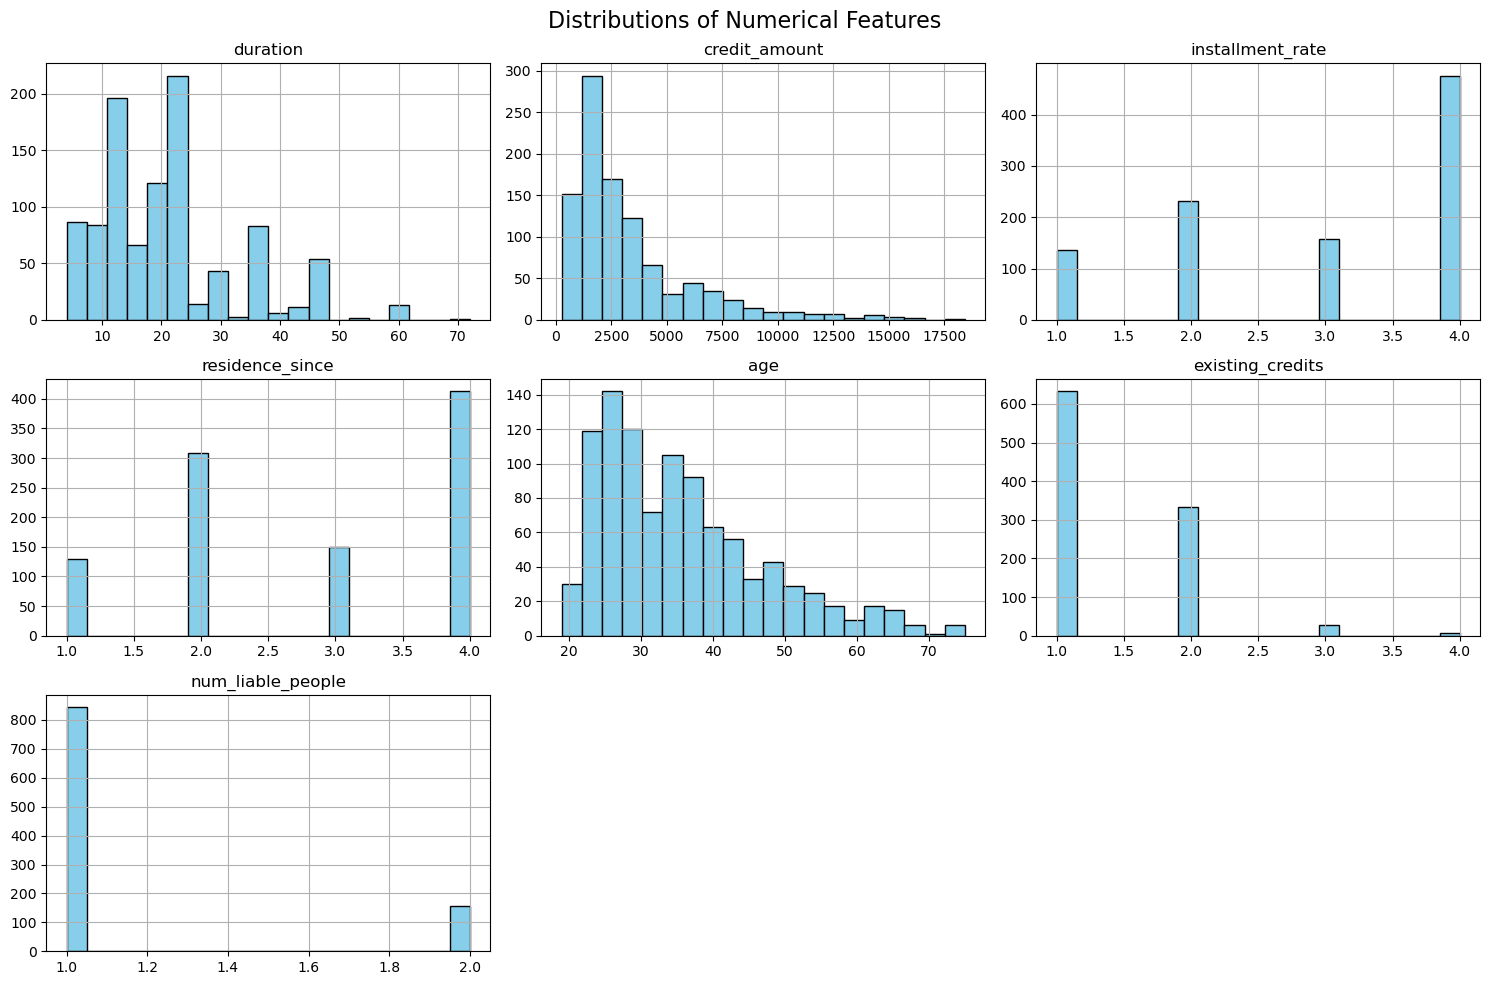

In [154]:

# Select only numeric feature columns (exclude target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('target')  # remove label column

print("Numeric feature columns:", numeric_cols)

# Plot
df[numeric_cols].hist(figsize=(15, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()




#df[numeric_cols].hist(figsize=(15, 10), bins=20, color='skyblue', edgecolor='black')
#plt.suptitle("Distributions of Numerical Features", fontsize=16)
#plt.tight_layout()
#plt.show()


####  4. Visualize some numerical features vs target:
Helps understand how numeric variables differ between good vs. bad credit.

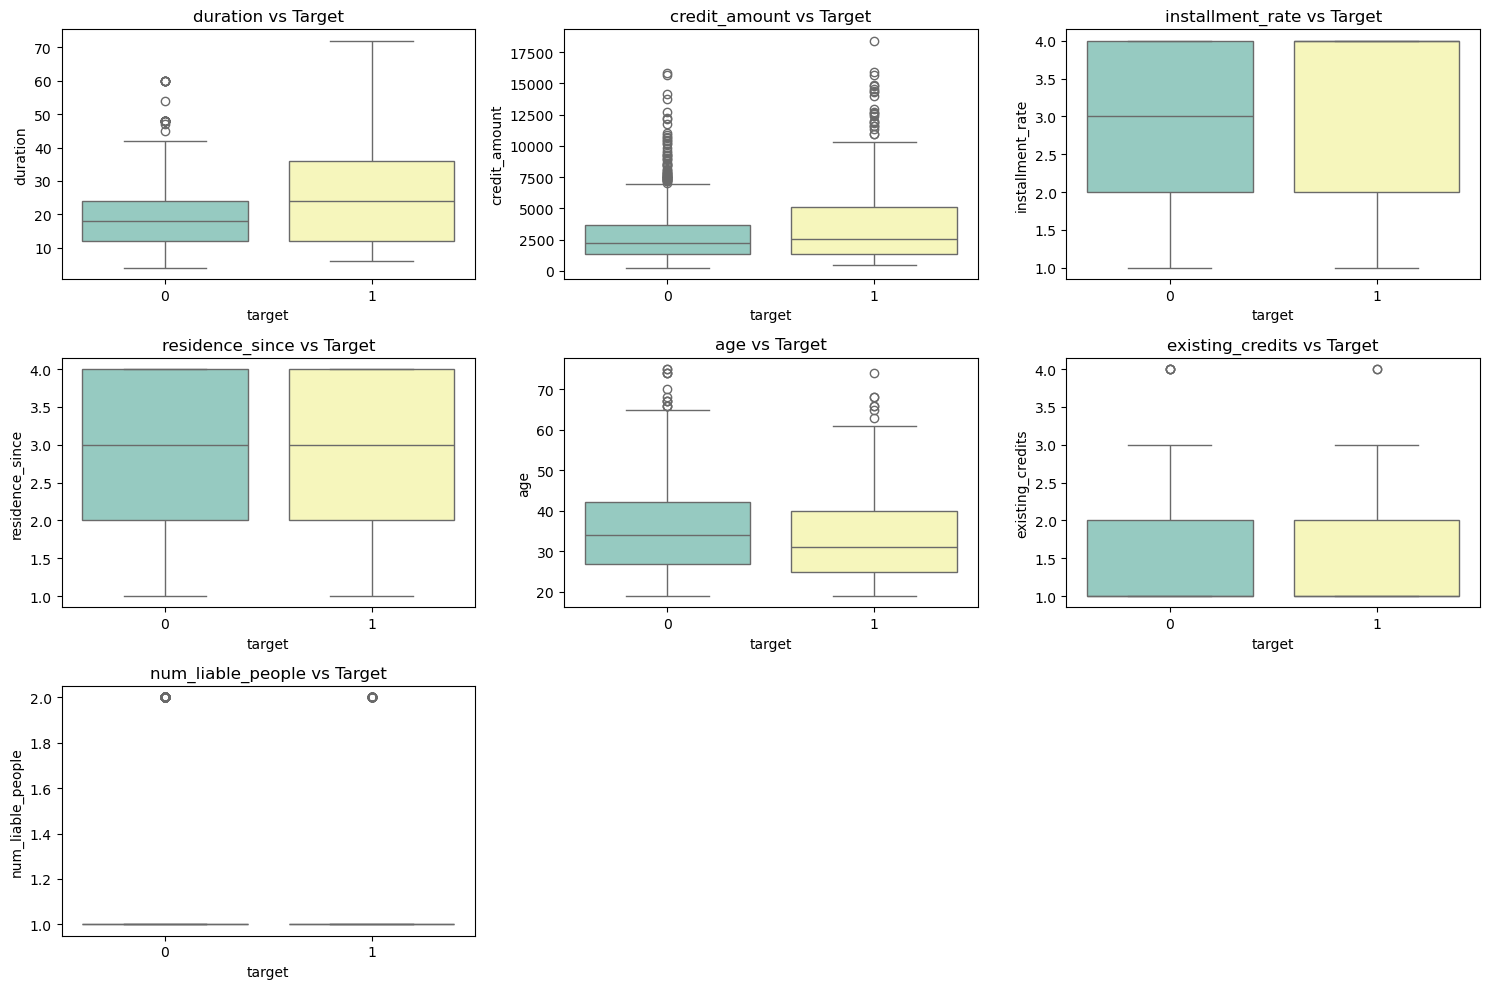

In [156]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='target', y=col, hue='target', data=df, palette='Set3', legend=False)
    plt.title(f"{col} vs Target")
plt.tight_layout()
plt.show()


#### 5. Categorical Feature Value Counts
Detects dominant values and rare categories.

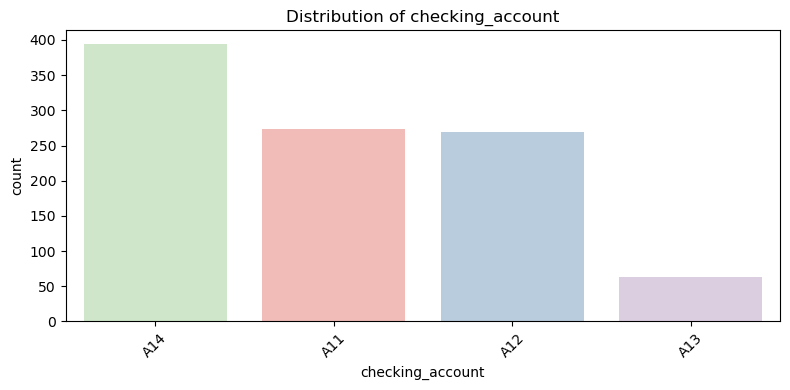

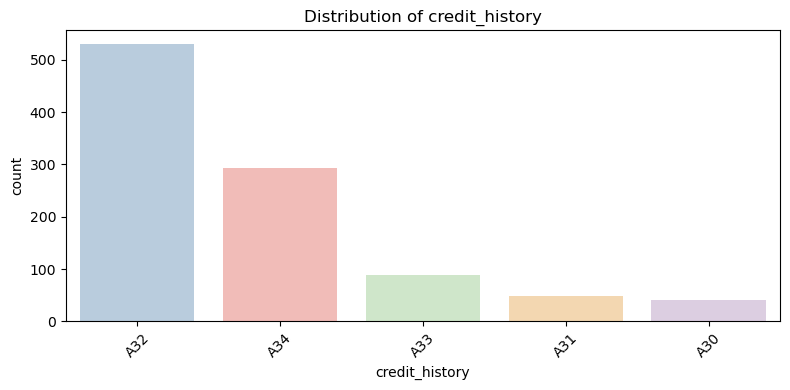

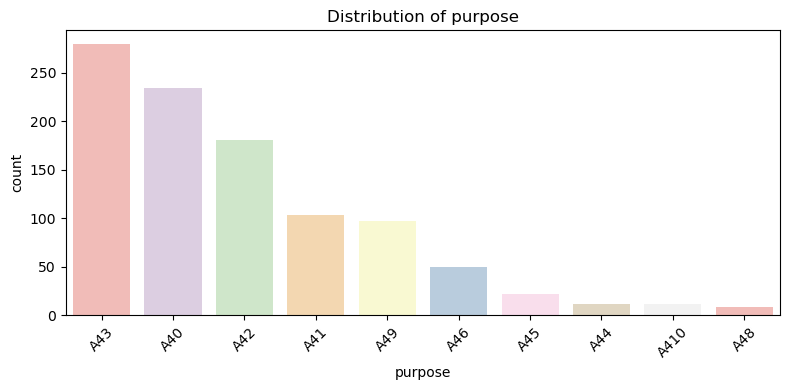

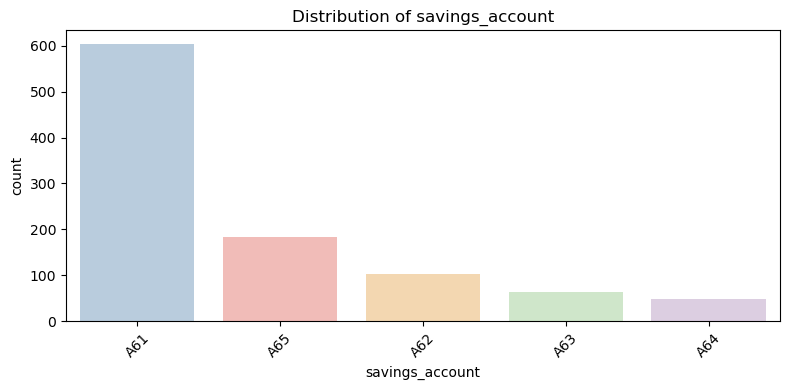

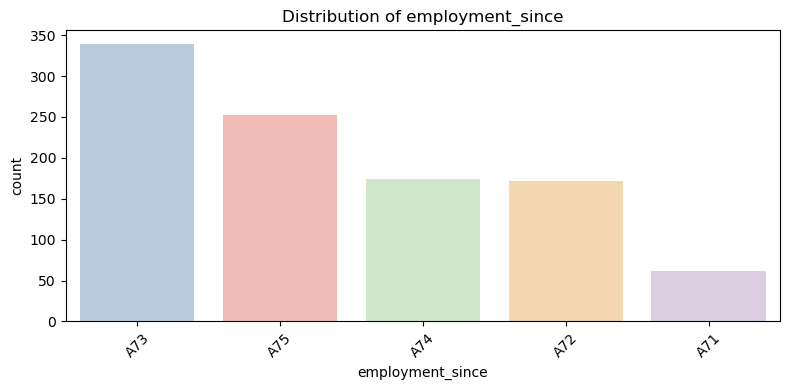

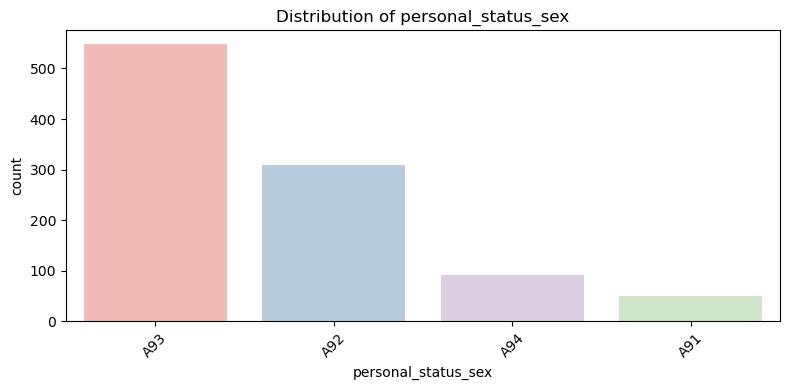

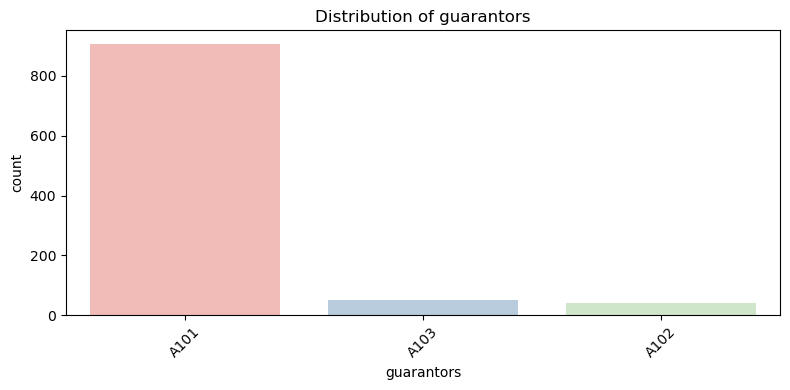

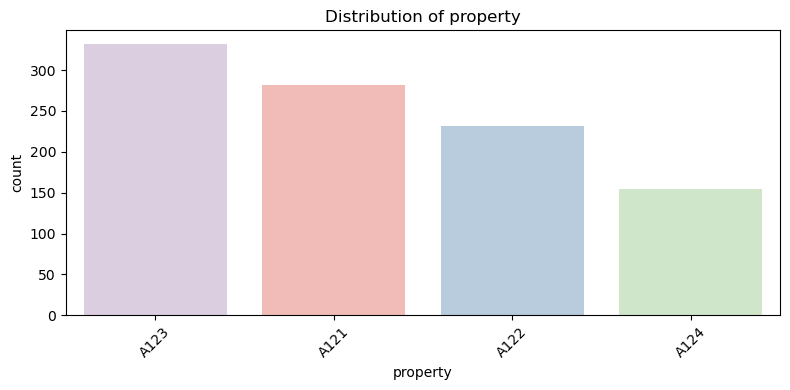

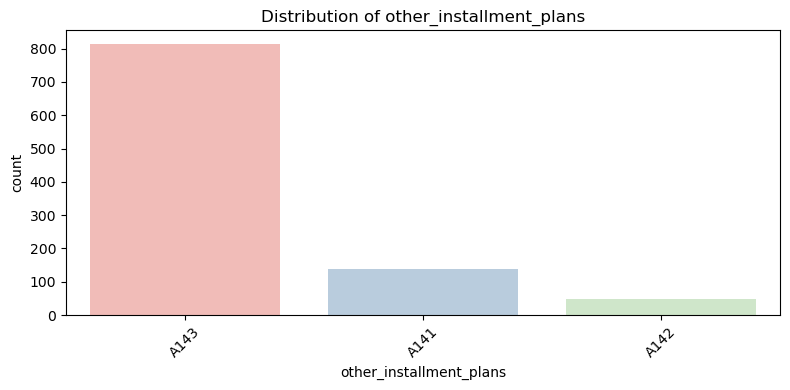

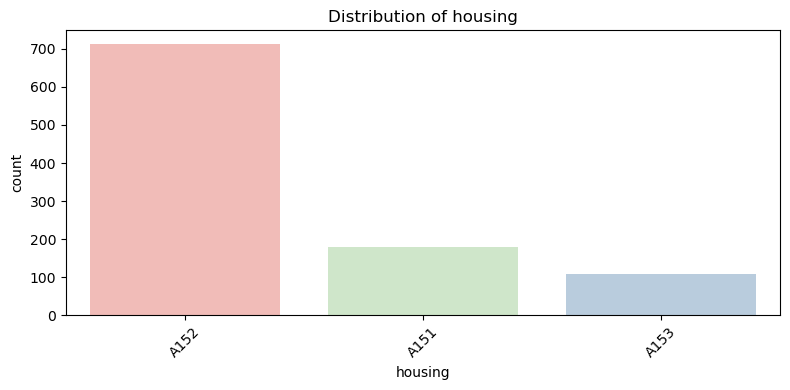

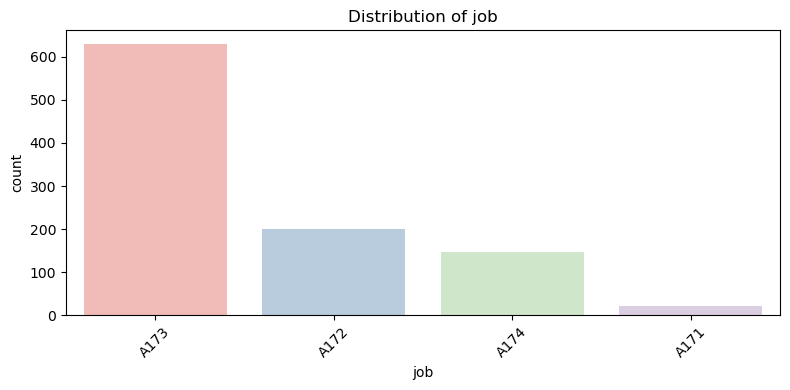

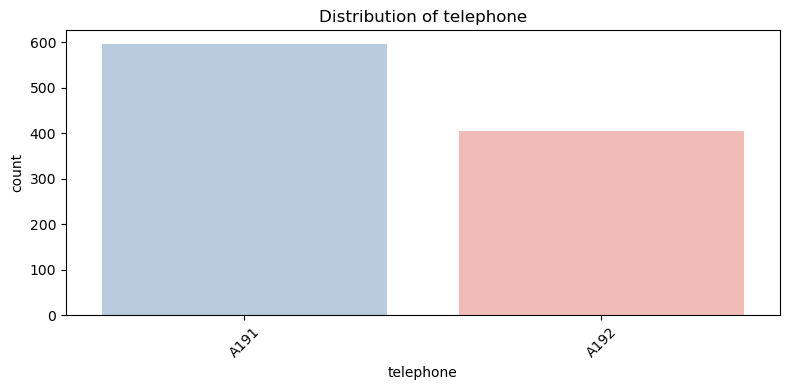

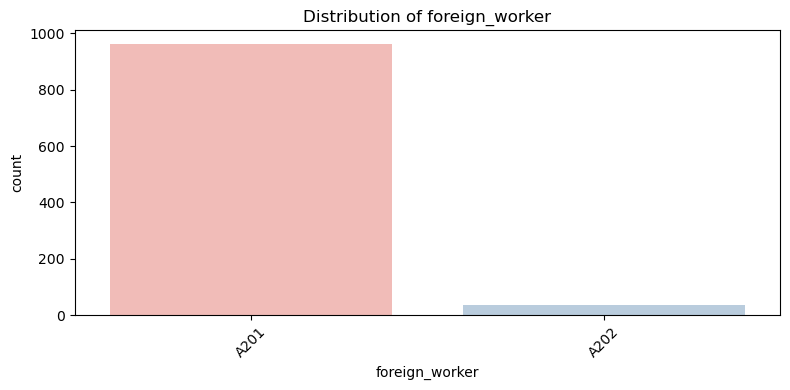

In [158]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue=col, order=df[col].value_counts().index, palette='Pastel1', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### 6. Categorical vs. Target
Helps find which categories are linked to high risk.

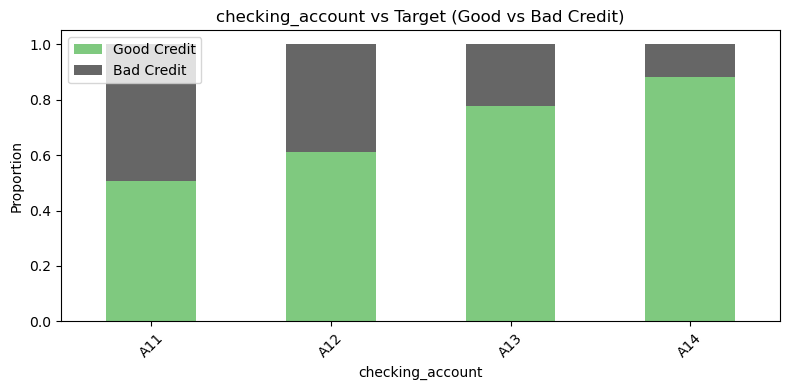

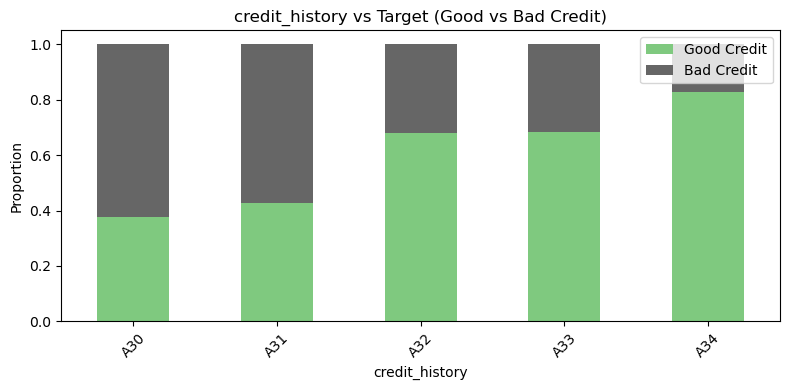

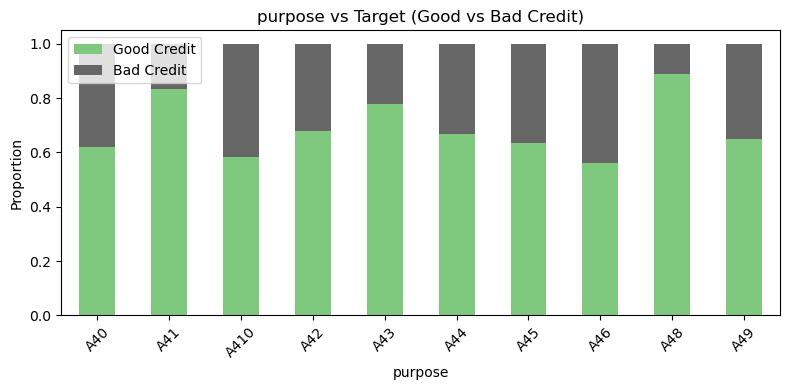

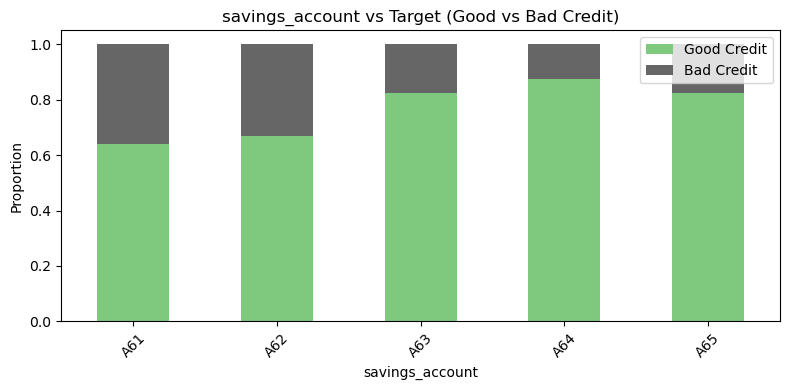

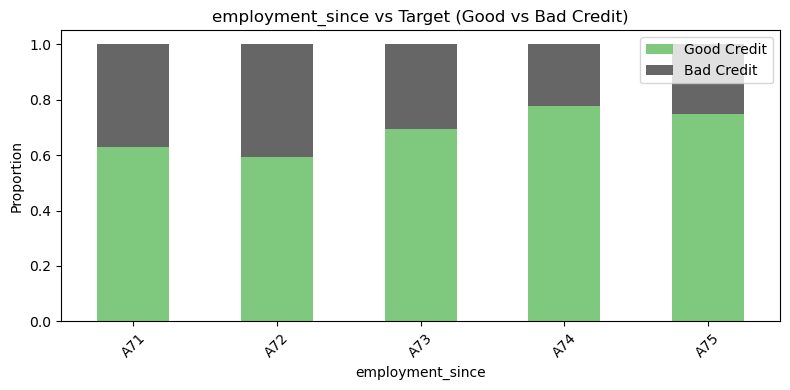

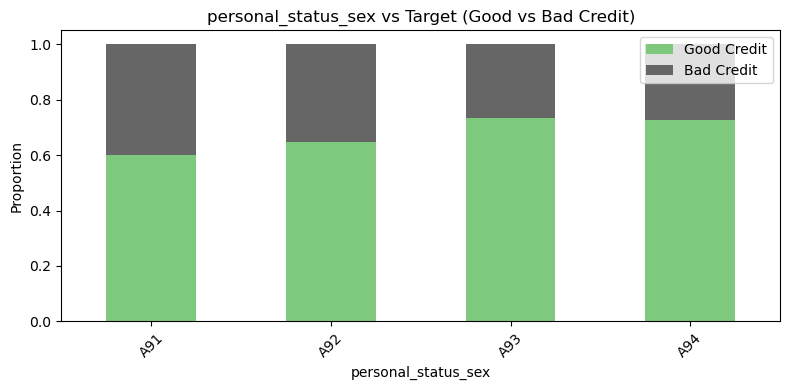

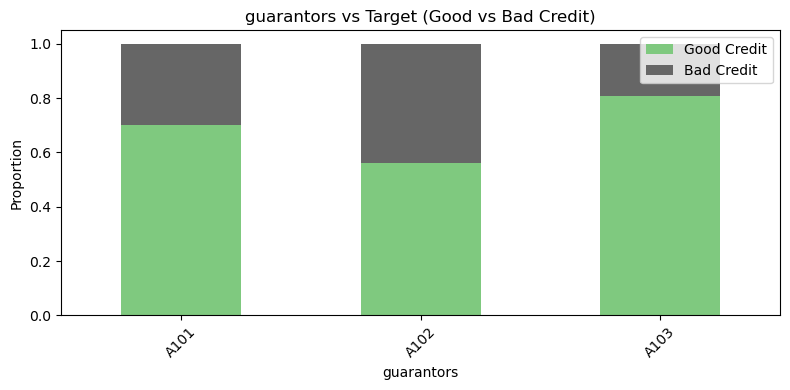

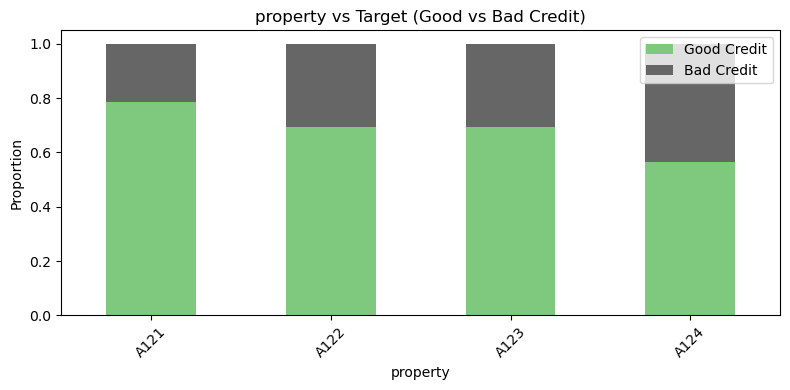

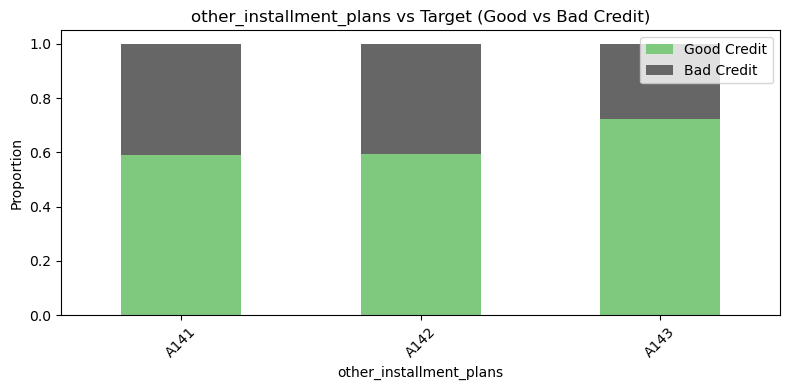

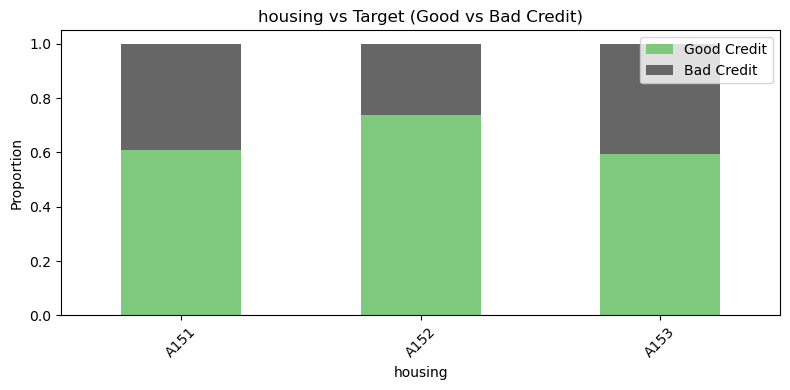

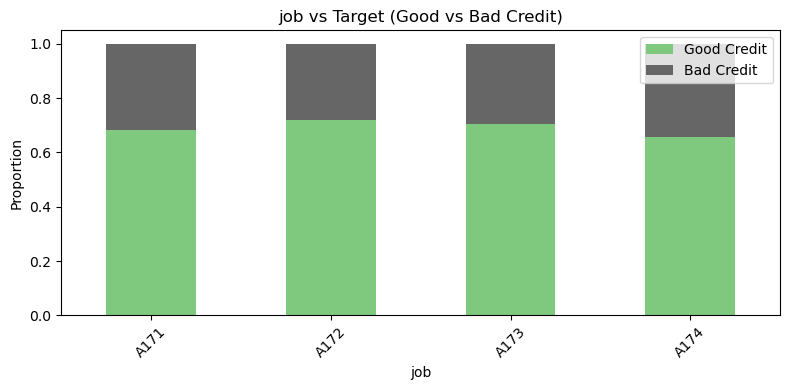

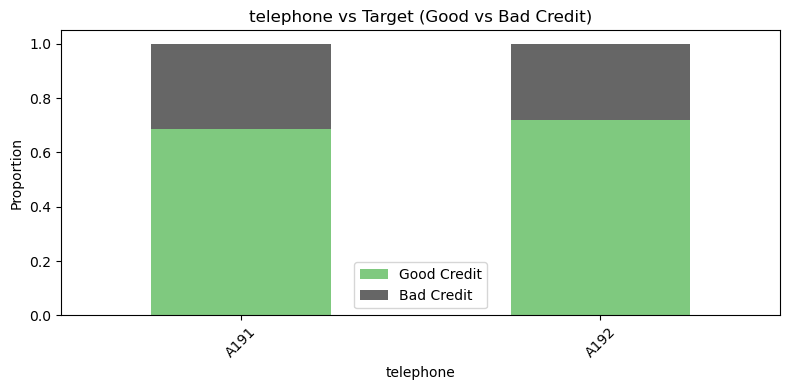

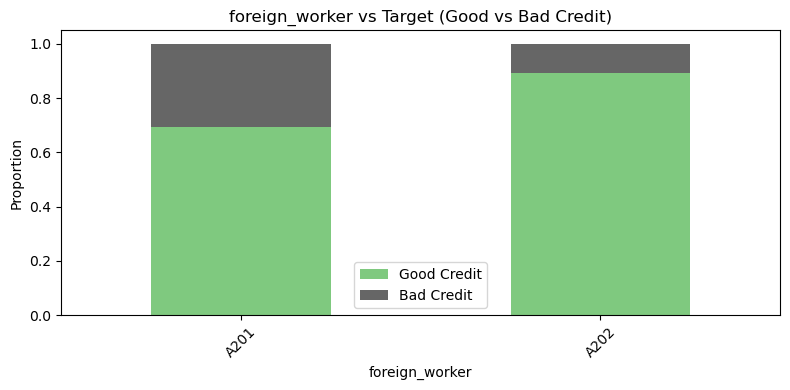

In [160]:
for col in categorical_cols:
    cross_tab = pd.crosstab(df[col], df['target'], normalize='index')
    
    # Rename target column values for better readability
    cross_tab.columns = ['Good Credit', 'Bad Credit']

    # Plot
    cross_tab.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='Accent')
    plt.title(f'{col} vs Target (Good vs Bad Credit)')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Step 3: Data Preprocessing (Encoding + Scaling)

#### 3.1: Separate Columns by Type

In [163]:
# Separate target from features
X = df.drop('target', axis=1)
y = df['target']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include='number').columns.tolist()


print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numeric_cols)


Categorical Columns: ['checking_account', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
Numerical Columns: ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_liable_people']


#### 3.2: Encoding Categorical Variables (One-Hot)

In [165]:

# One-hot encode the categorical features only in X
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Encoded feature set shape: {X_encoded.shape}")


Encoded feature set shape: (1000, 48)


#### 3.3: Feature Scaling (StandardScaler)

In [167]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale only the numerical columns in X_encoded
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

print("Feature scaling completed for numerical columns.")


Feature scaling completed for numerical columns.


#### 3.4: Train/Test Split

In [169]:

# Assign the processed features back to X
X = X_encoded  # Already only features, no 'target' column here

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (800, 48)
Test set shape: (200, 48)


### Step 4: Model Building + Evaluation

#### 4.1: Define Evaluation Function

In [172]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (AUC = {roc_auc_score(y_test, y_prob):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


#### 4.2: Logistic Regression

Confusion Matrix:
 [[102  38]
 [ 13  47]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80       140
           1       0.55      0.78      0.65        60

    accuracy                           0.74       200
   macro avg       0.72      0.76      0.72       200
weighted avg       0.79      0.74      0.75       200

Accuracy: 0.745
ROC-AUC: 0.8073809523809524


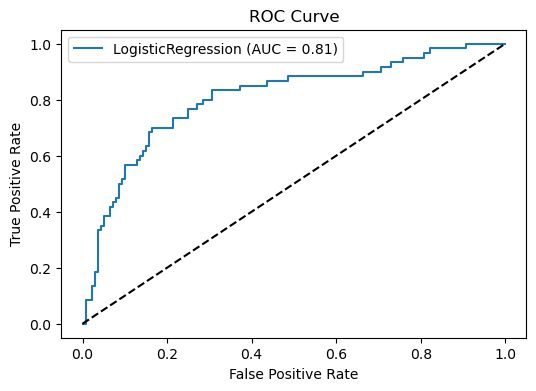

In [174]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
evaluate_model(logreg, X_test, y_test)


#### 4.4: Random Forest

Confusion Matrix:
 [[132   8]
 [ 40  20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       140
           1       0.71      0.33      0.45        60

    accuracy                           0.76       200
   macro avg       0.74      0.64      0.65       200
weighted avg       0.75      0.76      0.73       200

Accuracy: 0.76
ROC-AUC: 0.7889880952380953


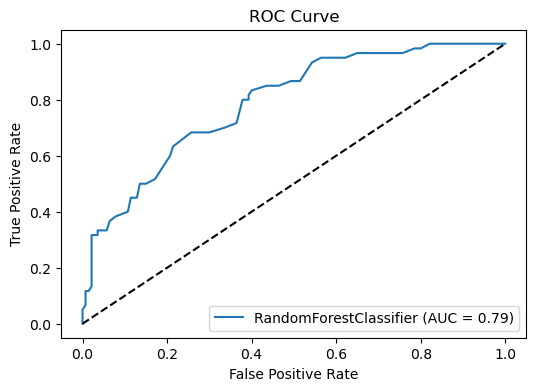

In [176]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)


#### 4.5: XGBoost

Confusion Matrix:
 [[114  26]
 [ 24  36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       140
           1       0.58      0.60      0.59        60

    accuracy                           0.75       200
   macro avg       0.70      0.71      0.71       200
weighted avg       0.75      0.75      0.75       200

Accuracy: 0.75
ROC-AUC: 0.8121428571428572


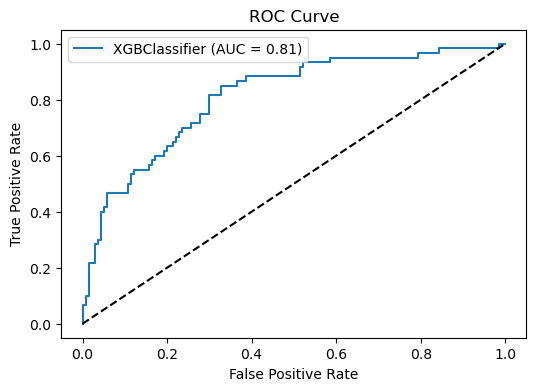

In [178]:
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=3, random_state=42)
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test)



#### set up hyperparameter tuning with GridSearchCV for  XGBoost model:

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validated F1 score: 0.5905493584726018
Confusion Matrix:
 [[107  33]
 [ 25  35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.79       140
           1       0.51      0.58      0.55        60

    accuracy                           0.71       200
   macro avg       0.66      0.67      0.67       200
weighted avg       0.72      0.71      0.71       200

Accuracy: 0.71
ROC-AUC: 0.7913095238095238


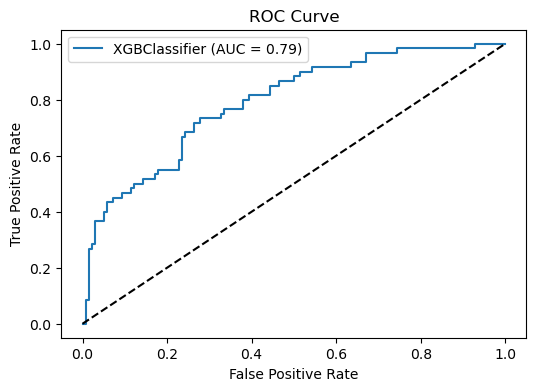

In [180]:

# Define the base model with fixed parameters

xgb_base = XGBClassifier(
    eval_metric='logloss',     # Still needed to avoid other warnings
    scale_pos_weight=3,        # Your class imbalance adjustment
    random_state=42            # For reproducibility
)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],       # Number of boosting rounds
    'max_depth': [3, 5, 7],           # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage
    'subsample': [0.8, 1.0]           # Row sampling ratio per tree
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',         # Optimize for F1 score (good for imbalanced classes)
    cv=5,                 # 5-fold cross-validation
    verbose=1,            # Progress messages
    n_jobs=-1             # Use all CPU cores
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Display best hyperparameters and best F1 score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

# Retrieve best model
best_xgb = grid_search.best_estimator_

# Evaluate best model on test set using the evaluation function defined earlier
evaluate_model(best_xgb, X_test, y_test)


 Here’s a professional side-by-side comparison for the two XGBoost models you ran:

| Metric                  | Baseline XGBoost         | Tuned XGBoost            |
| ----------------------- | ------------------------ | ------------------------ |
| **Confusion Matrix**    | \[\[114, 26], \[24, 36]] | \[\[107, 33], \[25, 35]] |
| **Accuracy**            | 0.75                     | 0.71                     |
| **Precision (Class 1)** | 0.58                     | 0.51                     |
| **Recall (Class 1)**    | 0.60                     | 0.58                     |
| **F1-Score (Class 1)**  | 0.59                     | 0.55                     |
| **ROC AUC Score**       | 0.812                    | 0.791                    |

### Interpretation:

* The **baseline XGBoost** model slightly outperforms the tuned model on all key metrics: accuracy, precision, recall, F1, and ROC AUC.
* Although hyperparameter tuning often improves model performance, here it appears the default parameters worked better, possibly because of the chosen parameter grid or the dataset’s characteristics.
* The tuned model has a higher false positive count (33 vs 26), which may mean more cases incorrectly predicted as positive.

---

### Recommendation:

For your **final model comparison** with Logistic Regression and Random Forest, I recommend **using the baseline XGBoost model** (without hyperparameter tuning), as it performs better on your test set.

---




#  Final Model Comparison & Practical Recommendation

## Model Performance Summary

| **Model**              | **Accuracy** | **Recall (Bad Credit)** | **Precision (Bad Credit)** | **ROC-AUC** | **Practical Notes** |
|------------------------|--------------|--------------------------|-----------------------------|-------------|----------------------|
| **Logistic Regression** | 0.745        | ✅ **0.78**              | 0.55                        | 0.807       | Interpretable, good baseline, strong recall |
| **Random Forest**       | 0.760        | 0.33                     | ✅ **0.71**                 | 0.789       | High accuracy but poor recall; favors majority class |
| **XGBoost**             | 0.750        | 0.60                     | 0.58                        | ✅ **0.812** | Best balance; handles class imbalance well |
| **Tuned XGBoost**       | 0.710        | 0.58                     | 0.51                        | 0.791       | Slight drop in accuracy and precision after tuning |

---

##  Business Goal

In **credit risk prediction**, the key business objective is to correctly **identify risky (bad credit) clients**:

- **High Recall for class 1** (Bad Credit) — to avoid approving risky applicants.
- **Good Precision** — to avoid falsely rejecting too many good clients.
- **High ROC-AUC** — to ensure strong overall class separation.

---

##  Recommended Final Model: **XGBoost (Default Parameters)**

We recommend using **XGBoost** because:

- ✅ Best balance of precision and recall
- ✅ Highest ROC-AUC (0.812)
- ✅ Performs well even without hyperparameter tuning
- ✅ Robust to data imbalance and noise

---


## Best Practical Model for a Bank: XGBoost (Default Parameters)

---

### 🔹 Why Banks Would Choose XGBoost in Practice

| **Factor**              | **XGBoost (Default)** | **Why it’s a Practical Winner**                                         |
|-------------------------|-----------------------|-------------------------------------------------------------------------|
| **Accuracy**            | 0.75                  | High overall prediction power                                           |
| **Recall (Bad Credit)** | 0.60                  | Catches most risky borrowers                                           |
| **ROC-AUC**             | 0.812                 | Best class separation – key for ranking credit risk                     |
| **Imbalance Handling**  | ✅ Yes                | Naturally handles class imbalance (fewer bad loans)                     |
| **Interpretability**    | Medium (with SHAP)    | Sufficient explainability using SHAP                                   |
| **Speed**               | Fast                  | Suitable for large datasets, online credit scoring systems             |
| **Scalability**         | ✅ Yes                | Can handle growing and real-time data streams                          |

---

###  Compared to Other Models

####  Logistic Regression
- ✅ Very interpretable (great for regulatory compliance)
- 🚫 Lower precision/recall for bad loans
- ✅ Best when **transparency** is more important than complex prediction
- 💡 Great as a **baseline or backup model** for audits

####  Random Forest
- ✅ High accuracy
- 🚫 **Very low recall** for bad credit → misses many risky customers
- 🚫 Not suitable for **risk-sensitive industries** like banking

---

##  Final Answer: Banks Should Use **XGBoost (Default)**

 **XGBoost** gives the best balance between:
- Business value  
- Prediction power   
- Real-world deployability   

>  **Recommendation:** Use **XGBoost** as the main model and **Logistic Regression** as a backup for explainability and compliance workflows.


## 1: Feature Importance Interpretation 

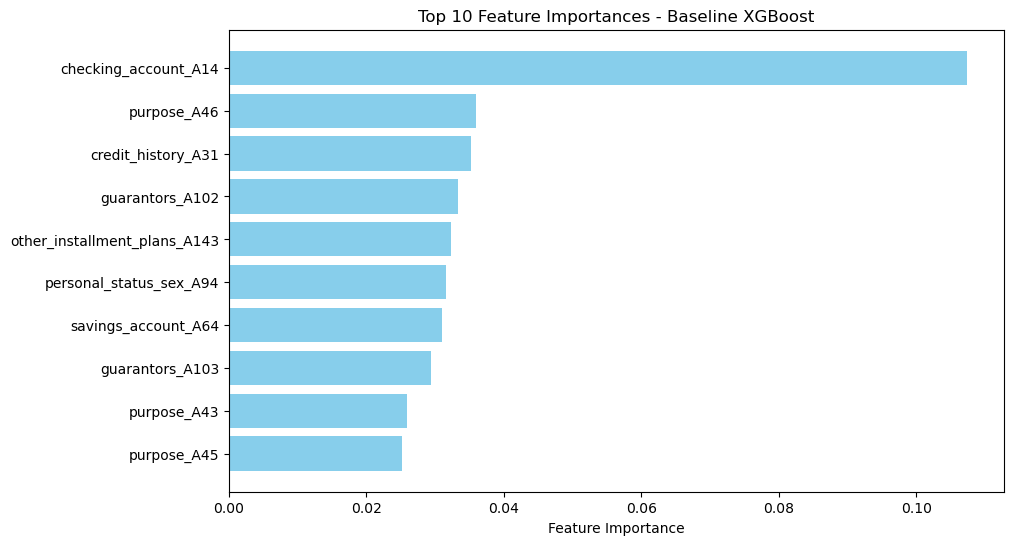

In [185]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances from the final model (baseline XGBoost)
importances = best_xgb.feature_importances_

# Create a DataFrame for easier visualization
feat_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance descending
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot top 10 features
plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['Feature'][:10][::-1], feat_importance_df['Importance'][:10][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Baseline XGBoost')
plt.show()


### Feature Importance Interpretation:

The feature importance analysis from the baseline XGBoost model reveals the most influential predictors driving credit risk classification. Features such as checking_account status, loan purpose, and credit history stand out as key contributors, indicating their critical role in assessing an applicant’s likelihood of default. Specifically, the model heavily relies on the current status of the applicant's checking account, reflecting financial stability. Additionally, certain loan purposes and past credit behaviors provide strong signals for risk assessment. This alignment with domain knowledge confirms that the model captures meaningful patterns relevant to creditworthiness, supporting its reliability for practical decision-making.

## Save the final model 

In [188]:
import joblib

joblib.dump(best_xgb, 'final_credit_risk_xgb_model.pkl')


['final_credit_risk_xgb_model.pkl']

### Prepare the Final DataFrame

In [190]:

# Your final dataframe with encoded features and target
df_encoded = X.copy()
df_encoded['target'] = y
# Map target values to labels
df_encoded['target'] = df_encoded['target'].map({0: 'Good', 1: 'Bad'})



### Download the CSV File in Jupyter

In [192]:
df_encoded.to_csv(r"C:\Users\ashid\Downloads\statlog+german+credit+data\final_credit_risk_data.csv", index=False)


In [193]:
import pandas as pd

# Load CSV into a DataFrame
df = pd.read_csv(r"C:\Users\ashid\Downloads\statlog+german+credit+data\final_credit_risk_data.csv")
df.head()



,duration,credit_amount,installment_rate,residence_since,age,existing_credits,num_liable_people,checking_account_A12,checking_account_A13,checking_account_A14,...,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202,target
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,False,False,False,...,False,True,True,False,False,True,False,True,False,Good
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,True,False,False,...,False,True,True,False,False,True,False,False,False,Bad
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,False,False,True,...,False,True,True,False,True,False,False,False,False,Good
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,False,False,False,...,False,True,False,True,False,True,False,False,False,Good
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,False,False,False,...,False,True,False,True,False,True,False,False,False,Bad


In [194]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   duration                      1000 non-null   float64
 1   credit_amount                 1000 non-null   float64
 2   installment_rate              1000 non-null   float64
 3   residence_since               1000 non-null   float64
 4   age                           1000 non-null   float64
 5   existing_credits              1000 non-null   float64
 6   num_liable_people             1000 non-null   float64
 7   checking_account_A12          1000 non-null   bool   
 8   checking_account_A13          1000 non-null   bool   
 9   checking_account_A14          1000 non-null   bool   
 10  credit_history_A31            1000 non-null   bool   
 11  credit_history_A32            1000 non-null   bool   
 12  credit_history_A33            1000 non-null   bool   
 13  cred

In [195]:
print(df.describe())


           duration  credit_amount  installment_rate  residence_since  \
count  1.000000e+03   1.000000e+03      1.000000e+03     1.000000e+03   
mean   9.592327e-17   7.638334e-17      1.065814e-17    -1.776357e-16   
std    1.000500e+00   1.000500e+00      1.000500e+00     1.000500e+00   
min   -1.402415e+00  -1.070865e+00     -1.764514e+00    -1.672459e+00   
25%   -7.386675e-01  -6.754833e-01     -8.701833e-01    -7.659773e-01   
50%   -2.408572e-01  -3.373443e-01      2.414692e-02     1.405047e-01   
75%    2.569531e-01   2.484620e-01      9.184772e-01     1.046987e+00   
max    4.239436e+00   5.370789e+00      9.184772e-01     1.046987e+00   

                age  existing_credits  num_liable_people  
count  1.000000e+03      1.000000e+03       1.000000e+03  
mean   4.973799e-17     -1.492140e-16      -1.065814e-17  
std    1.000500e+00      1.000500e+00       1.000500e+00  
min   -1.455261e+00     -7.049260e-01      -4.282896e-01  
25%   -7.516417e-01     -7.049260e-01      -4.2

In [196]:
df


,duration,credit_amount,installment_rate,residence_since,age,existing_credits,num_liable_people,checking_account_A12,checking_account_A13,checking_account_A14,...,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202,target
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,False,False,False,...,False,True,True,False,False,True,False,True,False,Good
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,True,False,False,...,False,True,True,False,False,True,False,False,False,Bad
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,False,False,True,...,False,True,True,False,True,False,False,False,False,Good
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,False,False,False,...,False,True,False,True,False,True,False,False,False,Good
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,False,False,False,...,False,True,False,True,False,True,False,False,False,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.544162,0.024147,1.046987,-0.399832,-0.704926,-0.428290,False,False,True,...,False,True,True,False,True,False,False,False,False,Good
996,0.754763,0.207612,0.918477,1.046987,0.391740,-0.704926,-0.428290,False,False,False,...,False,True,True,False,False,False,True,True,False,Good
997,-0.738668,-0.874503,0.918477,1.046987,0.215835,-0.704926,-0.428290,False,False,True,...,False,True,True,False,False,True,False,False,False,Good
998,1.999289,-0.505528,0.918477,1.046987,-1.103451,-0.704926,-0.428290,False,False,False,...,False,True,False,True,False,True,False,True,False,Bad
